<a href="https://colab.research.google.com/github/anujthapamagar/FEDS/blob/main/Final_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning
Use a simple (Deep) Neural network for regression task
The Task is to estimate the daily dynamics of the net ecosystem exchange (NEE)

# Download the data

In [12]:
import requests
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")

# If the data folder doesn't exist, download it and prepare it...
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping creation")
else: 
  print(f"{data_path} does not exist, creating one...")
  data_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "NEE_data.csv", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/stenoe/FEDS/main/data/NEE_data.csv")
  print("Downloading data...")
  f.write(request.content)

data directory already exists... skipping creation


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [14]:
df = pd.read_csv(data_path / "NEE_data.csv")
df.head()

,timestamp,Year,Month,Day,Hour,DoY,Tair_f,NEE_f,GPP_f,Reco
0,2020-01-01 00:00:00,2020,1,1,0.0,1,-1.823,0.93385,0.037139,0.970984
1,2020-01-01 00:30:00,2020,1,1,0.5,1,-2.031,0.73878,0.217870,0.956651
2,2020-01-01 01:00:00,2020,1,1,1.0,1,-2.285,1.05920,-0.119840,0.939356
3,2020-01-01 01:30:00,2020,1,1,1.5,1,-2.342,0.58402,0.351130,0.935153
4,2020-01-01 02:00:00,2020,1,1,2.0,1,-2.487,0.56388,0.361290,0.925168


# Import pytorch

In [15]:
import torch
from torch import nn

from sklearn.model_selection import train_test_split

torch.__version__

'2.0.1+cu118'

### 3.1 Lets write device agnostic code


In [16]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps_is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 4. Prepare the data for the use with PyTorch neural network

In [17]:
RANDOM_SEED = 42

X = torch.tensor(df[df.Month==6].Hour.to_numpy()).type(torch.float).unsqueeze(dim=1)
y = torch.tensor(df[df.Month==6].NEE_f.to_numpy()).type(torch.float).unsqueeze(dim=1)

# split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
test_size = 0.2,
random_state = RANDOM_SEED
)

X_train[:5], y_train[:5]

(tensor([[22.0000],
         [ 2.5000],
         [14.5000],
         [ 8.5000],
         [14.5000]]),
 tensor([[  5.4943],
         [  4.9038],
         [-13.6170],
         [ -8.8606],
         [ -8.7023]]))

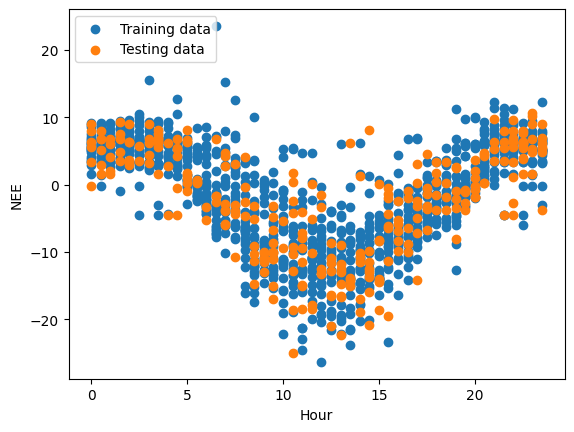

In [18]:
# Lets see how the data look like
plt.scatter(X_train, y_train, label = "Training data")
plt.scatter(X_test, y_test, label = "Testing data")
plt.xlabel("Hour")
plt.ylabel("NEE")
plt.legend(loc="upper left")

# 5. Set up the neural network

In [19]:
class DeepNormalNetwork(nn.Module):
  # need init constructor
  def __init__(self, n_inputs: int = 1, n_hidden: int = 10):
    super().__init__()
    self.hidden = torch.nn.Linear(n_inputs, n_hidden)
    self.mean_linear = torch.nn.Linear(n_hidden, 1)    

    # need to implement a forward step method
    def forward(self, x):
      outputs = self.hidden(x)
      outputs = torch.sigmoid(outputs)

      mean = self.mean_linear(outputs)
      return mean

model_0 = DeepNormalNetwork().to(device)



In [20]:
model_0

DeepNormalNetwork(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (mean_linear): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
# Define the loss function

loss_fn = nn.L1Loss()

# set an optimiser, use a ADAM (special gradient descent)
optimiser = torch.optim.Adam(params=model_0.parameters(), lr=0.05)


## 5.2 The heart of the learning algorithm - the training loop

1. switch to training mode
2. copy data to the GPU
3. calculate the forward pass/step and store this
4. calculate the loss
5. reset the gradients
6. make backward propagation
7. perform the optomiser step

To get some output on the progress:

1. switch to evaluation / inference mode
2. make a prediction with test data
3. calculate the loss of it
4. print results

In [22]:
# Training loop
torch.manual_seed(RANDOM_SEED)

epochs = 300

for epoch in range(epochs):
  # 1. switch to training mode
  model_0.train()

  # 2. copy data to GPU
  X_train = X_train.to(device)
  y_train = y_train.to(device)

  # 3. calculate the forward pass
  y_pred = model_0(X_train)

  # 4. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 5. set the optimiser grads to zero
  optimiser.zero_grad()

  # 6. Make backpropagation
  loss.backward()

  # 7. Make optimiser step
  optimiser.step()

  ## testing and see how the algorithm is performing
  if epoch % 20 == 0: # run every 20th time 
    # 1. switch to evaluation mode
    model_0.eval()

    with torch.inference_mode():
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred, y_test)

    # print what happens
    print(f"Model 0 - Epoch: {epoch} | Loss: {loss} | Test loss : {test_loss}")



NotImplementedError: ignored

## Evaluate with testing data

In [ ]:
model_0.eval()

with torch.inference_mode():
  y_pred = model_0(X_test)

In [ ]:
def plot_prediction(train_data = X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    prdictions=None,
                    ):
  plt.scatter(figsize=(10,7))

  # plot scatter of training data

  plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", alpha = 0,5, label ="Training data")

  
  plt.scatter(test_data.cpu(), test_labels.cpu(), c="b", alpha = 0.5, label ="Testing data")

  # do we have predictions?

  if predictions is not None:
    px = pd.DataFrame({
        "x" = np.ndarray.flatten(test_data.cpu().numpy(),
        "y" = np.ndarray.flatten(predictions.cpu().numpy()})
    px.sort_values(by="x", inplace = True)
    plt.plot(px.x,px.y, c="r", linewidth=3.0, label ="prediction")

  plt.legend();
  plt.xlabel("Hour")
  plt.ylabel("NEE")